In [1]:
#import
import os
import numpy as np
import scipy.io as sio
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_context('poster')
np.random.seed(0)

### Replication from White Matter Network Architecture Guides Direct Electrical Stimulation through Optimal State Transitions
Direct electrical brain stimulation is useful treatment for some neurological disorders (most famously, Parkinson's). However, we still don't really have a good way of predicting how stimulation at single region will influnce the rest of the brain. Here, we hypothesize that input from stimulation will spread linearly along white matter tracts to impact brain activity at distant regions. We use a dataset of combined iEEG, DWI, and stimulation data to simulate stimulation based on this hypothesis.

Data consist of one DWi structural adjacency matrix per dataset, and variable number of stimulation trials. Each stimulation trial includes the brain state before and after stimulation.

In [2]:
# load data
workdir = '/Users/stiso/Documents/Code/test_data/'
subj = ['R1067P.PS1_set1','R1051J.PS1_set1','R1051J.PS1_set2.1', 'R1030J.PS1_set1', 'R1124J_1.PS2_set2',
        'R1124J_1.PS2_set3','R1124J_1.PS2_set1', 'R1150J.PS2_set1','R1150J.PS2_set2','R1170J_1.PS2_1_set1',
        'R1170J_1.PS2_1_set2','R1067P.PS1_set1','R1068J.PS1_set2.1','R1089P.PS2_set1','R1062J.PS1_set1',
        'R1173J.PS2_1_set1','R1066P.PS1_set1'];
dat = sio.loadmat(f'{workdir}Trajectory_Data.{subj[0]}.mat')
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Electrode_ROI', 'Post_Freq_State', 'Post_Stim_Prob', 'Pre_Freq_State', 'Pre_Stim_Prob', 'Stim_Amp', 'Stim_Duration', 'Stim_Freq', 'Stim_Loc_Idx', 'Struct_Adj'])

In [3]:
prefix = subj[0].split('_set')[0]
target = sio.loadmat(f'{workdir}targets/{prefix}.mat')
target.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ROI_target'])

In [4]:
#set parameters
# these were the parameters were used in the the paper. they were chosen to minimuze error, 
# reults were validated in 2 additional parameter sets

# balance between minimizing energy or minimizing distance from target state
rho = .2  
# time to go from initial to target state
T = .7      
# the number of time points the code spits out: T * 1000 + 1
nTime = 701 
gamma = 4
# to try and simulate stimuluation, we're gonna weight the B matrix
B_mu = .0005 
B_sigma = .00005
scale = 250

#### Does it take more energy to get to a good, or bad memory state?

In [5]:
from network_control.utils import matrix_normalization
from network_control.energies import optimal_input
# intiialize final data strcutre
energies = pd.DataFrame(columns=['energy', 'condition', 'subject', 'trial', 'error'])

for i,s in enumerate(subj):
    prefix = subj[0].split('_set')[0]
    # load in data
    dat = sio.loadmat(f'{workdir}Trajectory_Data.{s}.mat')
    target = sio.loadmat(f'{workdir}targets/{prefix}.mat')
    
    # subject specific constants
    # number of stim trials for this set
    nTrial = np.size(dat['Post_Freq_State'],0)
    # number of nodes/regions in the atlas we are using - one of the complications of this project is that we 
    # dont have iEEG/state data for every regions of the atlas
    nROI = np.size(dat['Post_Freq_State'],1) 
    # number of bands
    nFreq = np.size(dat['Post_Freq_State'],2)
    # these are the regions with contacts
    elec_idx = np.sum(dat['Post_Freq_State'][:,:,0],0) != 0 
    ROI_idx = [not x for x in elec_idx]
    # number of contacts
    nElec = sum(elec_idx)
    # stim contacts
    stim_idx = [x[0][0] for x in dat['Stim_Loc_Idx']]

    # which regions we want to constrain the state of
    S = np.eye(nROI)
    
    # scale A matrix (continuous)
    # this variable will be the same for both datasets
    A = dat['Struct_Adj'] 
    A = matrix_normalization(A, c=gamma, version='continuous')

    # get optimal input and trajectory for each trial
    # each participant has a "good memory state", as determined by a linear classifier trained on memory performance
    xf = target['ROI_target']
    # this will take a while
    for t in range(nTrial):
        # get stim contacts
        e = stim_idx[t]
        
        # set sparse B matrix - ultimate goal is to have the majority of input be at the stim elecs
        # first, we set small input everywhere
        B = np.eye(nROI) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, nROI)) 
        # then we add 0s to all the areas whos activity we know
        B[elec_idx,elec_idx] = 0 
        # then, we add big numbers to the stim elecs
        for c in e:
            B[c,c] = 1

        # get states
        x0 = np.squeeze(dat['Pre_Freq_State'][t,:,:])

        # add 1s to regions without elecs
        x0[ROI_idx,:] = 1

        # concatenate across frequency bands
        u = np.zeros((nROI,nTime,nFreq))
        err = np.zeros((1,nFreq))
        for f in range(nFreq):
            _,curr_u, curr_err = optimal_input(A,T,B,x0[:,f],xf[:,f],rho,S)

            curr_u = curr_u.T
            err[:,f] = curr_err

            u[:,:,f] = curr_u
        
        # get summary of optimal input
        # we incorporated the B matrix into our input summary because of the weighting
        # we use the term energy to be consistent with other literature, but in some sense this is a different summary statistic
        u = sum(np.linalg.norm(u.T*np.diag(B),axis=(0,2)))/nTime

        # average over frequencies
        err = np.mean(err)


        # add to data frame (averaged over freqs)
        curr = pd.DataFrame({'energy':[np.mean(u)],
                             'initial_mem_state': dat['Pre_Stim_Prob'][0][t],
                             'subject':[s],
                             'trial':[t],
                             'error':[err]})
        energies = pd.concat([energies,curr],sort=False)

energies['log_eng'] = np.log(energies['energy']) 
energies['log_err'] = np.log(energies['error'])   


Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system
Normalizing A for a continuous-time system


Especially since we aren't using a full control set (B), we should check that errors are small before advancing

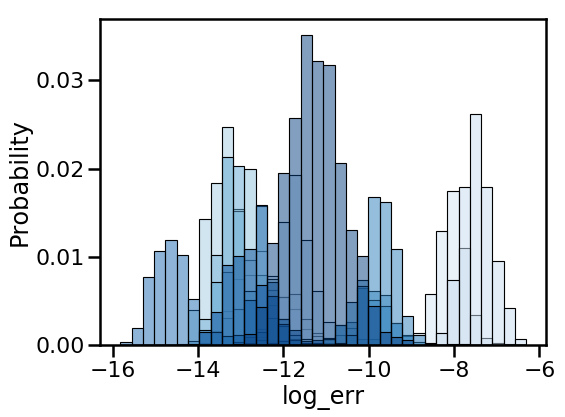

In [6]:
energies['log_eng'] = np.log(energies['energy']) 
energies['log_err'] = np.log(energies['error']) 
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.histplot(energies, x='log_err', hue='subject', stat='probability', 
             ax=ax, palette='Blues_r', legend=False)


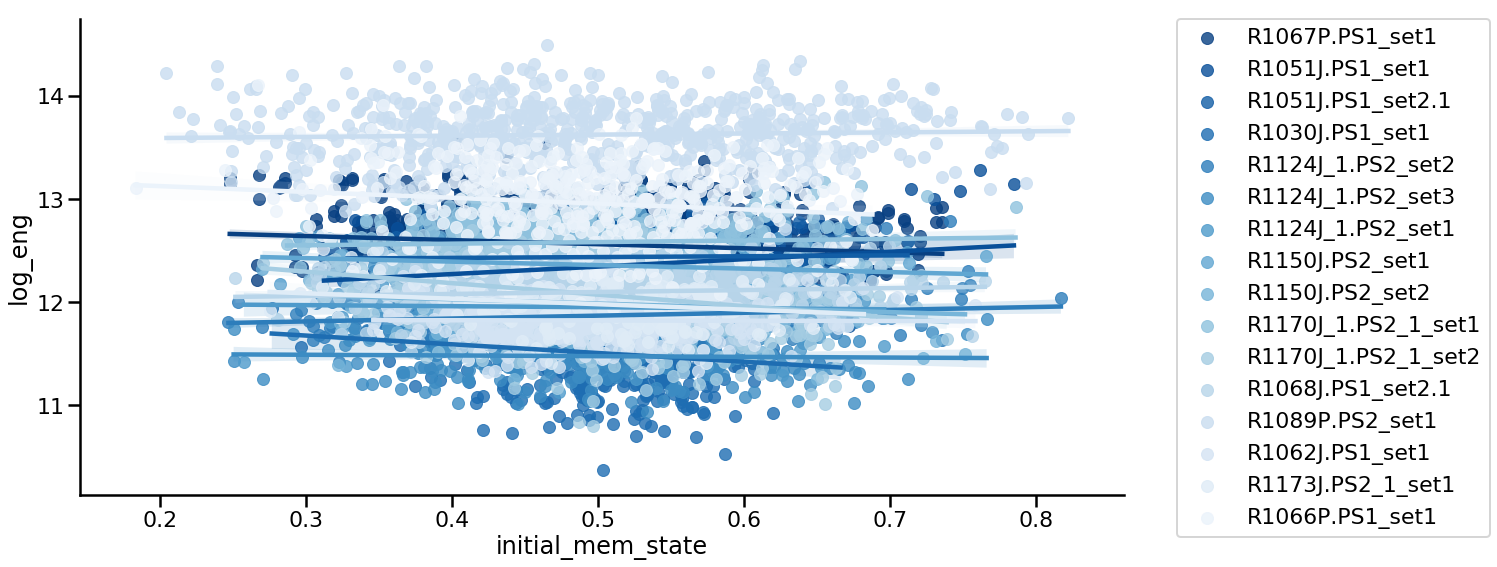

In [7]:
# this plot will look a little different from the original paper because we aren't z-scoring energy
sns.lmplot(data=energies, y='log_eng', x = 'initial_mem_state', hue = 'subject', palette='Blues_r',
          height=8, aspect=2, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As we can see, for most participants, transitions to good memory states require more energy when starting from a poorer memory state. In the paper, we show that the initial memory state explains more variane than the Euclidean distance between states as well.